In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

# 학습 모델 저장을 위한 라이브러리
import pickle

# statsmodels API 불러오기
import statsmodels.api as sm

from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sys

누적 상대 중요도 90% 까지 필요한 피처 수: 389


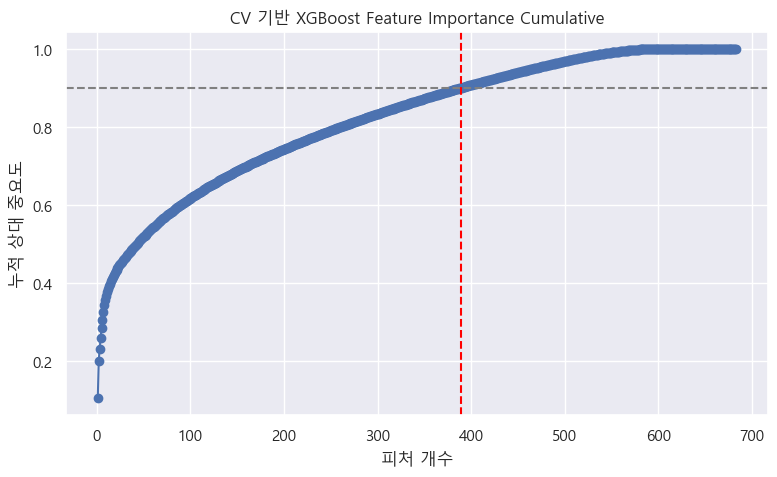

In [2]:
# TRAIN 데이터 로드 및 불필요 컬럼 제거
train_df = pd.read_csv("merged_2018_train.csv")
X_full   = train_df.drop(columns=['ID', 'Segment', '기준년월'])
y        = train_df['Segment']

# 문자열 레이블을 숫자로 인코딩
le    = LabelEncoder()
y_enc = le.fit_transform(y)  # 'A'→0, 'B'→1, ..., 'E'→4


# 숫자형 피처만 선택 및 스케일링
num_feats = X_full.select_dtypes(include=[np.number]).columns.tolist()
X_num     = X_full[num_feats]
scaler    = StandardScaler()
X_s       = scaler.fit_transform(X_num)
df_vif    = pd.DataFrame(X_s, columns=num_feats, index=train_df.index)


# CV 기반 XGBoost 중요도 추출
skf           = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
imp_mat       = np.zeros((skf.get_n_splits(), len(num_feats)))

for fold, (tr_idx, _) in enumerate(skf.split(X_s, y_enc)):
    model = XGBClassifier(eval_metric='logloss', random_state=42)
    model.fit(X_s[tr_idx], y_enc[tr_idx])
    imp_mat[fold, :] = model.feature_importances_

# 중요도 집계 및 누적 상대 중요도 계산
mean_imp = imp_mat.mean(axis=0)
df_imp   = (
    pd.DataFrame({'feature': num_feats, 'importance': mean_imp})
      .sort_values('importance', ascending=False)
      .reset_index(drop=True)
)
df_imp['rel_imp']     = df_imp['importance'] / df_imp['importance'].sum()
df_imp['cum_rel_imp'] = df_imp['rel_imp'].cumsum()

# 완만해지는 지점 찾기 & 시각화
threshold = 0.90
n_keep    = (df_imp['cum_rel_imp'] <= threshold).sum() + 1
print(f"누적 상대 중요도 {threshold*100:.0f}% 까지 필요한 피처 수: {n_keep}")

plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(df_imp)+1), df_imp['cum_rel_imp'], marker='o')
plt.axhline(threshold, color='gray', linestyle='--')
plt.axvline(n_keep, color='red', linestyle='--')
plt.xlabel('피처 개수')
plt.ylabel('누적 상대 중요도')
plt.title('CV 기반 XGBoost Feature Importance Cumulative')
plt.tight_layout()
plt.show()

### 누적 상대 중요도로 구한 피쳐들 VIF 값 구해서 기준 초과 피처 제거 후 PCA

In [3]:
# 누적 상대 중요도 기준 상위 피처 리스트 (389개)
threshold = 0.90
n_keep    = (df_imp['cum_rel_imp'] <= threshold).sum() + 1
top_features = df_imp.loc[:n_keep-1, 'feature'].tolist()

print(f"CV 중요도 기반 필터링 후 피처 개수: {len(top_features)}개")  # → 389

# df_vif를 389개 피처로 제한
df_vif_sub = df_vif[top_features]

# inf → NaN → 중앙값 대체
X0  = df_vif_sub.replace([np.inf, -np.inf], np.nan)
imp = SimpleImputer(strategy='median')
df_vif_clean = pd.DataFrame(
    imp.fit_transform(X0),
    columns=top_features,
    index=df_vif_sub.index
)

print(f"결측 대체 후 피처 개수: {df_vif_clean.shape[1]}개")  # → 389

# VIF 계산 및 진행률 표시 (389개 대상)
threshold_vif = 10
X_const = sm.add_constant(df_vif_clean, has_constant='add')

vif_vals = []
total    = X_const.shape[1] - 1  # const 제외

for i in range(1, total+1):
    vif_vals.append(variance_inflation_factor(X_const.values, i))
    sys.stdout.write(f'\rVIF 계산중: {i}/{total}')
    sys.stdout.flush()
print('\nVIF 계산 완료.')

# 기준 초과 피처 일괄 제거 및 개수 출력
vif_df   = pd.DataFrame({
    'feature': X_const.columns[1:],  # const 제외
    'vif':     vif_vals
})

high_vif = vif_df.loc[vif_df['vif'] > threshold_vif, 'feature'].tolist()
print(f"VIF > {threshold_vif}인 피처 (제거 대상): {len(high_vif)}개")

df_vif_clean.drop(columns=high_vif, inplace=True)
print(f"VIF 필터링 후 남은 피처 개수: {df_vif_clean.shape[1]}개")

CV 중요도 기반 필터링 후 피처 개수: 389개
결측 대체 후 피처 개수: 389개
VIF 계산중: 389/389
VIF 계산 완료.
VIF > 10인 피처 (제거 대상): 272개
VIF 필터링 후 남은 피처 개수: 117개


In [4]:
# PCA 적용 (분산 95% 유지)
pca       = PCA(n_components=0.95, random_state=42)
pca_feats = pca.fit_transform(df_vif_clean)  
print(f"PCA로 생성된 주성분 개수: {pca_feats.shape[1]}")
pca_df    = pd.DataFrame(pca_feats, columns=[f"PC{i+1}" for i in range(pca_feats.shape[1])])
print(pca_df.head())
print(pd.Series(pca.explained_variance_ratio_, index=pca_df.columns))

PCA로 생성된 주성분 개수: 84
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  1.836402  4.453430 -0.592406 -1.094352  3.851754  5.494464 -0.900641   
1 -0.101151  1.137616 -1.878508 -0.518519 -1.445530 -0.500546  0.201335   
2  0.858373  3.616767  0.139966  0.486430 -1.362274  0.025749  1.491245   
3  3.954065  6.532468  0.678895 -1.103741  4.936234  6.941170  1.754631   
4 -2.058507 -2.033788 -0.604518 -0.649020  1.231210 -0.173891 -0.719983   

        PC8       PC9      PC10  ...      PC75      PC76      PC77      PC78  \
0 -0.538084 -1.799202  0.433028  ...  0.240803 -1.059680 -1.020216 -2.348623   
1 -0.919842  0.499208  0.599539  ... -0.131397 -0.137223 -0.166699 -0.165560   
2 -1.078230  1.809223 -1.474503  ... -0.887725 -0.372162  0.154219  0.717465   
3 -1.557625 -2.016883  1.192908  ...  1.909106  0.694918 -1.857318 -0.280186   
4 -0.927053 -0.312972  9.576877  ...  0.083613  0.561969  0.119994 -0.535010   

       PC79      PC80      PC81      PC82      P

In [5]:
# VIF 필터링된 데이터에 ID·Segment 추가하여 CSV 저장
vif_data = pd.concat([
    train_df.loc[df_vif_clean.index, ['ID', 'Segment']],
    df_vif_clean.reset_index(drop=True)
], axis=1)
vif_data.to_csv("vif.csv", index=False)

# PCA 결과에 ID·Segment 추가하여 CSV 저장
pca_columns = [f"PC{i+1}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feats, columns=pca_columns, index=df_vif_clean.index)
pca_data = pd.concat([
    train_df.loc[df_vif_clean.index, ['ID', 'Segment']],
    pca_df.reset_index(drop=True)
], axis=1)
pca_data.to_csv("pca_features.csv", index=False)

### 누적 상대 중요도로 구한 피쳐들 PCA

In [8]:
# 1) CV 기반 상위 n_keep개 피처 리스트 추출
top_features = df_imp.loc[:n_keep-1, 'feature'].tolist()

# 2) df_vif에서 해당 피처만 서브셋
X_selected = df_vif[top_features]

# 3) inf → NaN → 중앙값 대체
X0  = X_selected.replace([np.inf, -np.inf], np.nan)
imp = SimpleImputer(strategy='median')
X_imputed = imp.fit_transform(X0)

# 4) PCA 적용 (분산 95% 유지)
pca = PCA(n_components=0.95, random_state=42)
pca_feats = pca.fit_transform(X_imputed)

# 5) 결과 확인
print(f"95% 분산을 설명하는 주성분 개수: {pca.n_components_}")
pca_df = pd.DataFrame(
    pca_feats,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=train_df.index
)
print(pca_df.head())
print(pd.Series(pca.explained_variance_ratio_, index=pca_df.columns))

95% 분산을 설명하는 주성분 개수: 124
         PC1        PC2        PC3       PC4       PC5        PC6        PC7  \
0   2.699111  13.232003  -6.379687 -0.387869  3.901301 -12.350903 -10.289617   
1  -0.524378   1.694718  -1.855387 -3.450539  1.375130   0.155163   2.292363   
2  12.323774  17.931468 -13.346922  2.687983  1.840005 -11.640233 -11.598259   
3   9.380181  19.281059  -0.724570 -2.090784  0.840318 -12.342025  -8.655591   
4  -7.442729  -1.751156   2.391000  4.254425  1.712911   0.588975  -1.069735   

        PC8       PC9      PC10  ...     PC115     PC116     PC117     PC118  \
0 -1.135494  0.072606 -4.091458  ...  0.893507 -1.004951 -0.698274  0.765328   
1  1.973241 -1.900539 -2.449442  ...  0.181584  0.133501 -0.218307 -0.569199   
2 -3.283831  5.939967 -3.758882  ... -0.044769  0.661070  0.446295 -0.507620   
3 -2.818717 -5.895514  3.096878  ...  0.419352  0.519742  0.743579 -0.127591   
4 -3.219302  1.450683  2.709746  ... -0.251772 -0.120436  0.619745  0.307448   

      PC119  

In [9]:
# PCA 결과에 Segment 컬럼을 추가하고 CSV로 저장
pca_df['Segment'] = train_df.loc[pca_df.index, 'Segment']
pca_df.to_csv("pca_features_with_segment.csv", index=False)